<a href="https://colab.research.google.com/github/DotBion/techgb2336-dataSciBiz/blob/main/Copy_of_HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HW2: Predicting Patient No-Shows

### Background

You've been hired as the manager of SHMC, a medical center in Brazil. As part of its business model, SHMC usually employs doctors on demand, meaning that doctors are asked to come only when there are appointments. However, once a doctor has been asked to come, you must pay him or her regardless of whether the patient shows up or not. You want to use data on previous appointments to figure out whether you can predict which patients are going to show up, so that you can plan better how many doctors to call.

[The data can be downloaded at this link.](https://drive.google.com/uc?download=export&id=1iM0CSzfNckc565zwpb4VpHjEVLgckLPE)


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Loading the data

**1. Load the data referenced by the path above into a pandas data frame. Comment on the total number of rows and columns, and show the first few rows in the dataset.**

In [2]:
noshows = pd.read_csv('SHMC_NoShows.csv')

print(noshows.shape)
noshows.head()

(110527, 14)


,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighborhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589980e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262960e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679510e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841190e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


Here's a brief summary of the features in the data:

1. PatientId - Identification of a patient.
2. AppointmentID - Identification of each appointment.
3. Gender - Male or female.
4. ScheduledDay - The day someone called or registered the appointment.
6. AppointmentDay - The day of the actual appointment, when the patient has to visit the doctor.
7. Age = How old is the patient.
8. Neighborhood - Place where the patient lives.
9. Scholarship - Whether the patient receives financial help.(0=No, 1=Yes)
10. Hypertension - Whether the patient suffers from hypertension.(0=No, 1=Yes)
11. Diabetes - Whether the patient suffers from diabetes.(0=No, 1=Yes)
12. Alcoholism - Whether the patient suffers from alcoholism.(0=No, 1=Yes)
13. Handicap - Whether the patient is handicapped (0=No, 1=Yes)
14. SMS_received - Whether 1 or more SMS messages were sent to the patient (0=No, 1=Yes)
15. No-show - Whether the patient missed the appointment.

### Exploratory Data Analysis

**2. Transform ScheduledDay and AppointmentDay into datetimes (Hint: Use pandas for this). What is the range of dates of the AppointmentDay?**

In [3]:
# prompt: Transform ScheduledDay and AppointmentDay into datetimes

noshows['ScheduledDay'] = pd.to_datetime(noshows['ScheduledDay'])
noshows['AppointmentDay'] = pd.to_datetime(noshows['AppointmentDay'])

print("Range:",noshows['AppointmentDay'].min(), noshows['AppointmentDay'].max())


Range: 2016-04-29 00:00:00+00:00 2016-06-08 00:00:00+00:00


**3. If you take a look at both dates, you will see that ScheduledDay includes a specific time with the date, but AppointmentDay doesn't. In order to compare both fields more easily, apply "normalize" to ScheduledDay (i.e., keep only the dates). Hint: See the [normalize](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.dt.normalize.html) method.**

In [4]:
print(noshows['ScheduledDay'][0],noshows['AppointmentDay'][0])
noshows['ScheduledDay'] = noshows['ScheduledDay'].dt.normalize()
print(noshows['ScheduledDay'][0],noshows['AppointmentDay'][0])

2016-04-29 18:38:08+00:00 2016-04-29 00:00:00+00:00
2016-04-29 00:00:00+00:00 2016-04-29 00:00:00+00:00


**4. Create a new feature called 'TimeInAdvance' which is the difference in days between ScheduledDay and AppointmentDay.  (you may need to apply `dt.days`  to a datetime object to make sure this is a numeric). What is the longest advance time that someone scheduled an appointment??**

In [5]:
noshows['TimeInAdvance'] = (noshows['AppointmentDay'] - noshows['ScheduledDay']).dt.days
print(noshows['TimeInAdvance'].max())

179


**5. Explore the data set using EDA functions we have discussed in class.  Look at each feature.  Do any of them contain missing or weird values or outliers that concern you, given the feature descriptions above?  Comment on any weird values you see in any of the columns? Remove observations that contain any strange observations you have no explanation for, and report on how many rows were removed.**

In [28]:
print(noshows['ScheduledDay'].max())
print(noshows['AppointmentDay'].max())
print(noshows['ScheduledDay'].min())
print(noshows['AppointmentDay'].min())

#negative age values are not practical, 0 is possible for child less than a year old.
print(noshows['Age'].min())
count_negative_ages = (noshows['Age'] < 0).sum()
print(count_negative_ages)
#negative values for TimeInAdvance shows that the appointment dates are before the scheduling dates: why ?
print(noshows['TimeInAdvance'].min())
count_negative_timeinadvance = (noshows['TimeInAdvance'] < 0).sum()
print(count_negative_timeinadvance)


2016-06-08 00:00:00+00:00
2016-06-08 00:00:00+00:00
2015-11-10 00:00:00+00:00
2016-04-29 00:00:00+00:00
-1
1
-6
5


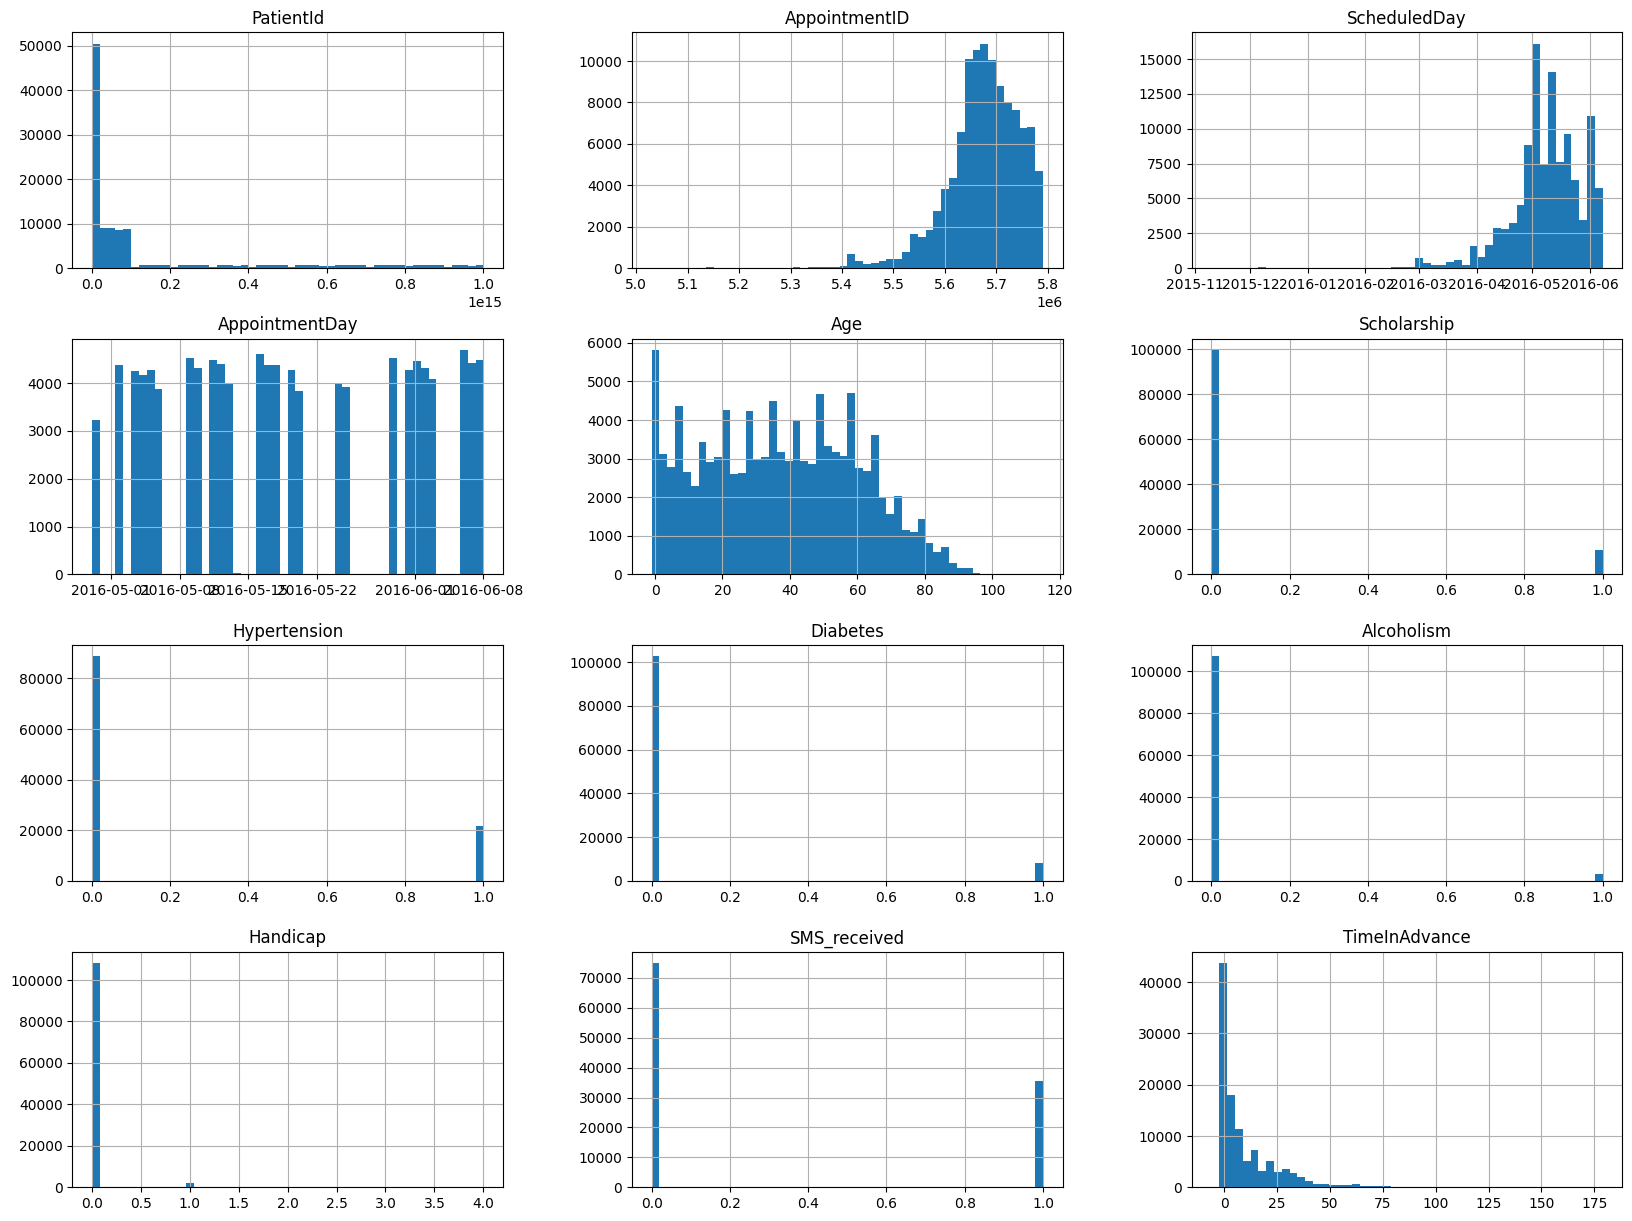

In [10]:
noshows.hist(bins=50, figsize=(20, 15))
#noshows.hist(bins=15, edgecolor='black', grid=False, figsize=(15, 10), layout=(5, 5))
plt.show()

In [25]:
#checking for missing values
na_count=noshows.isna().sum()
na_count

,0
PatientId,0
AppointmentID,0
Gender,0
ScheduledDay,0
AppointmentDay,0
Age,0
Neighborhood,0
Scholarship,0
Hypertension,0
Diabetes,0


In [32]:
count_negative_timeinadvance = (noshows['TimeInAdvance'] < 0).sum()
print(count_negative_timeinadvance)
count_negative_ages = (noshows['Age'] < 0).sum()
print(count_negative_ages)

5
0


In [33]:
#Removing negative TimeInAdvance values
rows_before = len(noshows)
noshows = noshows[noshows['TimeInAdvance'] >= 0]
rows_after = len(noshows)
print(f"Removed {rows_before - rows_after} rows with negative TimeInAdvance.")

Removed 5 rows with negative TimeInAdvance.


In [29]:
# prompt: Explore the data set using EDA functions we have discussed in class. Look at each feature. Do any of them contain missing or weird values or outliers that concern you, given the feature descriptions above? Comment on any weird values you see in any of the columns? Remove observations that contain any strange observations you have no explanation for, and report on how many rows were removed.

# Check for missing values
print(noshows.isnull().sum())

# Check data types and descriptive statistics
print(noshows.info())
print(noshows.describe())

# Explore individual features
print(noshows['Age'].value_counts()) # Check for unusual age values
print(noshows[noshows['Age'] < 0]) # Look at negative ages specifically

# Remove rows with negative ages
rows_before = len(noshows)
noshows = noshows[noshows['Age'] >= 0]
rows_after = len(noshows)
print(f"Removed {rows_before - rows_after} rows with negative ages.")


# Explore other features for inconsistencies (e.g., 'Gender', 'Scholarship', etc.)
print(noshows['Gender'].value_counts())
print(noshows['Scholarship'].value_counts())
print(noshows['Hypertension'].value_counts())
print(noshows['Diabetes'].value_counts())
print(noshows['Alcoholism'].value_counts())
print(noshows['Handicap'].value_counts())
print(noshows['SMS_received'].value_counts())
print(noshows['No-show'].value_counts())

# Examine 'TimeInAdvance' for unusual values
print(noshows['TimeInAdvance'].describe())
print(noshows[noshows['TimeInAdvance'] < 0]) # Check for negative time differences


#Further Investigation (example)
#If there are any values that seem odd, investigate and comment on them.
#Example: If you find a patient with an extremely high age or negative TimeInAdvance
#Consider removing those as well or adjusting them.
#This would be an example of how to remove outliers based on other factors
# rows_before = len(noshows)
# noshows = noshows[(noshows['TimeInAdvance'] >= 0)]
# rows_after = len(noshows)
# print(f"Removed {rows_before - rows_after} rows with negative TimeInAdvance.")

#Visualizations for Outlier Detection
#plt.figure(figsize=(10, 6))
#sns.boxplot(x=noshows['Age'])
#plt.show()




PatientId         0
AppointmentID     0
Gender            0
ScheduledDay      0
AppointmentDay    0
Age               0
Neighborhood      0
Scholarship       0
Hypertension      0
Diabetes          0
Alcoholism        0
Handicap          0
SMS_received      0
No-show           0
TimeInAdvance     0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype              
---  ------          --------------   -----              
 0   PatientId       110527 non-null  float64            
 1   AppointmentID   110527 non-null  int64              
 2   Gender          110527 non-null  object             
 3   ScheduledDay    110527 non-null  datetime64[ns, UTC]
 4   AppointmentDay  110527 non-null  datetime64[ns, UTC]
 5   Age             110527 non-null  int64              
 6   Neighborhood    110527 non-null  object             
 7   Scholarship     110527 non-null  int64           

In [69]:
#Handicap column has values more than 1 which should not be right as it is a categorical data
false_handicaps = noshows['Handicap'].isin([0,1])
false_handicaps_count = sum(false_handicaps==False)
print("Removed for Handicap > 1: ",  false_handicaps_count)

Removed for Handicap > 1:  199


In [73]:
print("Total rows removed: " ,(false_handicaps_count+count_negative_ages+count_negative_timeinadvance))


Total rows removed:  204


<Axes: >

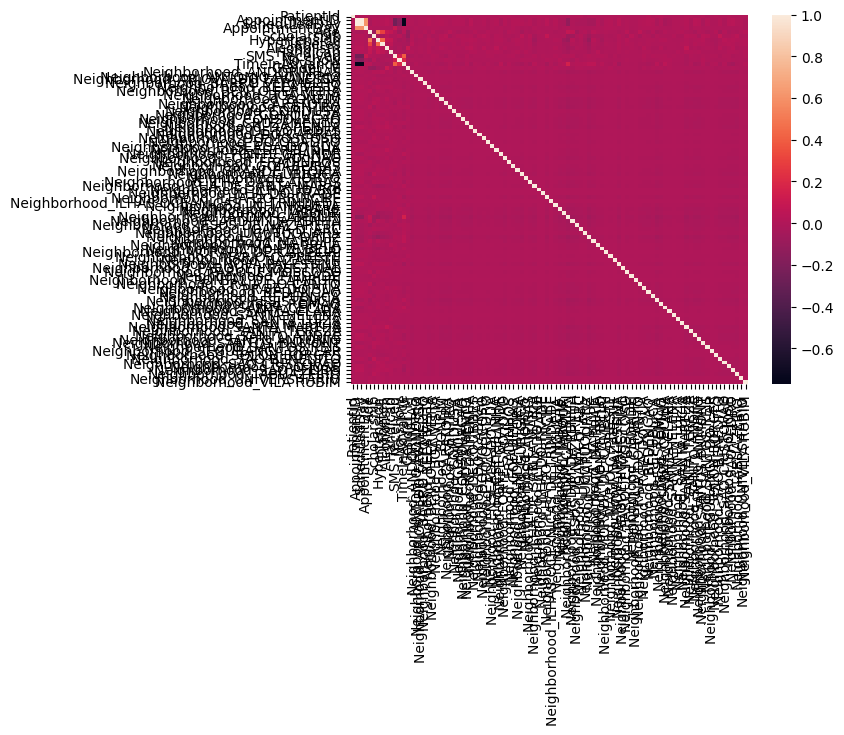

In [40]:
#changing the gender column to use the correlation function
#noshows['Gender'] = noshows['Gender'].replace({'M': 1, 'F': 0})
noshows_copy = noshows.copy()
noshows_copy = pd.get_dummies(noshows_copy, columns=['Gender','Neighborhood'], drop_first=True)
noshows_copy.head()


#corr = noshows_copy.corr()
#sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)

#corr = noshows.corr()
#sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)
#sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns,vmin=-1,vmax=1,cmap="RdBu")

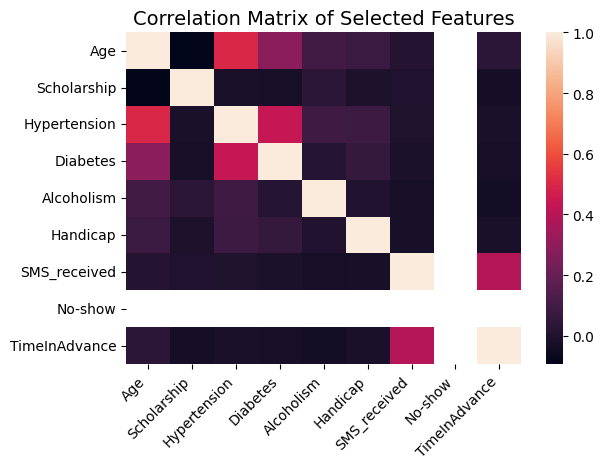

In [45]:
selected_columns = ['Age', 'Scholarship', 'Hypertension', 'Diabetes', 'Alcoholism',
                    'Handicap', 'SMS_received', 'No-show', 'TimeInAdvance']
noshows_copy['No-show'] = noshows_copy['No-show'].map({'No': 0, 'Yes': 1})
correlation_matrix = noshows_copy[selected_columns].corr()
# Create heatmap
#plt.figure(figsize=(12, 10))  # Adjust figure size as needed
sns.heatmap(correlation_matrix, xticklabels=correlation_matrix.columns, yticklabels=correlation_matrix.columns)
#sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f",linewidths=.5, annot_kws={"size": 10})

plt.title('Correlation Matrix of Selected Features', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)  # Rotate x-axis labels
plt.yticks(fontsize=10)
plt.tight_layout()  # Adjust layout to prevent overlapping labels
plt.show()

**6. Create a new column called "IsFemale" that is 1 if the patient is female and 0 otherwise. Also, drop the Gender column.**

In [48]:
noshows['IsFemale'] = (noshows['Gender'] == 'F').astype(int)
noshows.drop('Gender', axis=1, inplace=True)
noshows.head()

,PatientId,AppointmentID,ScheduledDay,AppointmentDay,Age,Neighborhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,No-show,TimeInAdvance,IsFemale
0,2.987250e+13,5642903,2016-04-29 00:00:00+00:00,2016-04-29 00:00:00+00:00,62,JARDIM DA PENHA,0,1,0,0,0,0,No,0,1
1,5.589980e+14,5642503,2016-04-29 00:00:00+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,0,0,0,0,0,No,0,0
2,4.262960e+12,5642549,2016-04-29 00:00:00+00:00,2016-04-29 00:00:00+00:00,62,MATA DA PRAIA,0,0,0,0,0,0,No,0,1
3,8.679510e+11,5642828,2016-04-29 00:00:00+00:00,2016-04-29 00:00:00+00:00,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,0,1
4,8.841190e+12,5642494,2016-04-29 00:00:00+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,1,1,0,0,0,No,0,1


**7. Do the same for the No-show variable. It should be 1 if the person didn't show and 0 otherwise.**

In [49]:
noshows['No-show'] = (noshows['No-show'] == 'No').astype(int)
noshows.head()

,PatientId,AppointmentID,ScheduledDay,AppointmentDay,Age,Neighborhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,No-show,TimeInAdvance,IsFemale
0,2.987250e+13,5642903,2016-04-29 00:00:00+00:00,2016-04-29 00:00:00+00:00,62,JARDIM DA PENHA,0,1,0,0,0,0,1,0,1
1,5.589980e+14,5642503,2016-04-29 00:00:00+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,0,0,0,0,0,1,0,0
2,4.262960e+12,5642549,2016-04-29 00:00:00+00:00,2016-04-29 00:00:00+00:00,62,MATA DA PRAIA,0,0,0,0,0,0,1,0,1
3,8.679510e+11,5642828,2016-04-29 00:00:00+00:00,2016-04-29 00:00:00+00:00,8,PONTAL DE CAMBURI,0,0,0,0,0,0,1,0,1
4,8.841190e+12,5642494,2016-04-29 00:00:00+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,1,1,0,0,0,1,0,1


**8. Now we explore the `Neighborhood` feature.  It is a categorical with many levels (as can be seen from `value_counts`).  To simplify the analysis we are going to create a new verison of `Neighborhood` by re-labelling any neighborhoods that appear LESS THAN 2000 times and give them the label Neighborhood="OTHER".  Show a table of value_counts of your *new* Neighborhood feature.**

In [58]:
neighborhood_counts=noshows['Neighborhood'].value_counts()
neighborhood_counts
#Filter for neighborhoods with counts less than 2000:
less_frequent_neighborhoods = neighborhood_counts[neighborhood_counts < 2000]
#print(less_frequent_neighborhoods)
#Get the names of the less frequent neighborhoods:
less_frequent_neighborhood_names = less_frequent_neighborhoods.index
#print(less_frequent_neighborhood_names)
#Replace the less frequent neighborhood names with "OTHER":
noshows['Neighborhood'] = noshows['Neighborhood'].replace(less_frequent_neighborhood_names, 'OTHER')
print(noshows['Neighborhood'].value_counts())


Neighborhood
OTHER                43878
JARDIM CAMBURI        7717
MARIA ORTIZ           5805
RESISTÊNCIA           4430
JARDIM DA PENHA       3877
ITARARÉ               3514
CENTRO                3334
TABUAZEIRO            3131
SANTA MARTHA          3131
JESUS DE NAZARETH     2853
BONFIM                2773
SANTO ANTÔNIO         2744
SANTO ANDRÉ           2571
CARATOÍRA             2565
JABOUR                2509
SÃO PEDRO             2448
ILHA DO PRÍNCIPE      2266
NOVA PALESTINA        2264
ANDORINHAS            2262
DA PENHA              2217
ROMÃO                 2214
GURIGICA              2018
Name: count, dtype: int64


**9. Create dummy variables for your new Neighborhood feature, add the dummies to your data frame, and then drop the original Neighborhood column from the data frame. Print a `head()` of your new data frame.**

In [59]:
noshows = pd.get_dummies(noshows, columns=['Neighborhood'], drop_first=True)
noshows.head()

,PatientId,AppointmentID,ScheduledDay,AppointmentDay,Age,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,...,Neighborhood_MARIA ORTIZ,Neighborhood_NOVA PALESTINA,Neighborhood_OTHER,Neighborhood_RESISTÊNCIA,Neighborhood_ROMÃO,Neighborhood_SANTA MARTHA,Neighborhood_SANTO ANDRÉ,Neighborhood_SANTO ANTÔNIO,Neighborhood_SÃO PEDRO,Neighborhood_TABUAZEIRO
0,2.987250e+13,5642903,2016-04-29 00:00:00+00:00,2016-04-29 00:00:00+00:00,62,0,1,0,0,0,...,False,False,False,False,False,False,False,False,False,False
1,5.589980e+14,5642503,2016-04-29 00:00:00+00:00,2016-04-29 00:00:00+00:00,56,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
2,4.262960e+12,5642549,2016-04-29 00:00:00+00:00,2016-04-29 00:00:00+00:00,62,0,0,0,0,0,...,False,False,True,False,False,False,False,False,False,False
3,8.679510e+11,5642828,2016-04-29 00:00:00+00:00,2016-04-29 00:00:00+00:00,8,0,0,0,0,0,...,False,False,True,False,False,False,False,False,False,False
4,8.841190e+12,5642494,2016-04-29 00:00:00+00:00,2016-04-29 00:00:00+00:00,56,0,1,1,0,0,...,False,False,False,False,False,False,False,False,False,False


**10. There are many patients that have made more than one appointment. This data set contains multiple observations per person, so we can use their past appointments as features in predicting whether the current appointment will be a no-show.**

**For example, the fact that a patient has failed to show up in the past may be predictive of the patient not showing up in the future. We want to create a variable that calculates the number of no_shows BEFORE the current appointment.**

**Create a new column called "PreviousNoShows" that for each appointment includes the number of *previous* appointments to which the patient did not show. For example, if the person did not show to the first meeting, PreviousNoShows should be 0 for the first appointment and 1 for the second one (if there is any). (We have provided sample code for this part below, but take a look at it to see if it makes sense to you, and edit to use your data frame name).**

**Now, create a line plot showing - for each value of PreviousNoShows, what is the percent No-Shows for the current appointment.  Does there seem to be a relationship? That is, does the number of PREVIOUS no-shows seem to be predictive of a no-show for the CURRENT appointment?  Comment.**

In [61]:
## sample code for calculating PreviousNoShows- make sure to replace "df" with your data frame name

noshows = noshows.sort_values(['PatientId', 'ScheduledDay'])
noshows['PreviousNoShows'] = noshows.groupby(['PatientId'])['No-show'].cumsum()- noshows['No-show']

In [65]:
noshows['PreviousNoShows'].value_counts()

,count
PreviousNoShows,
0,68949
1,22584
2,8890
3,3926
4,1934
...,...
82,1
83,1
84,1


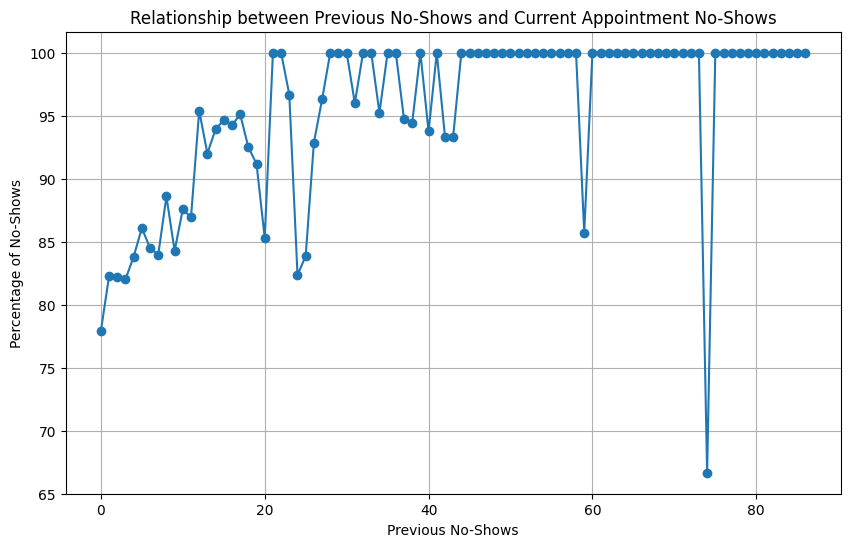

In [67]:
# Calculate the percentage of no-shows for each value of PreviousNoShows
previous_noshows_percentages = noshows.groupby('PreviousNoShows')['No-show'].mean() * 100

# Create the line plot
plt.figure(figsize=(10, 6))
plt.plot(previous_noshows_percentages.index, previous_noshows_percentages.values, marker='o')
plt.xlabel('Previous No-Shows')
plt.ylabel('Percentage of No-Shows')
plt.title('Relationship between Previous No-Shows and Current Appointment No-Shows')
plt.grid(True)
plt.show()

# The plot suggests a positive relationship between the number of previous no-shows
# and the likelihood of a no-show for the current appointment. As the number of previous
# no-shows increases, the percentage of no-shows for the current appointment also tends
# to increase. This indicates that patients with a history of no-shows are more likely to
# miss their future appointments, supporting the idea that 'PreviousNoShows' could be a
# predictive feature for no-show prediction.

### Predictive modeling using Trees

**11. Let's drop the columns we won't be needing. Drop PatientId, AppointmentID, ScheduledDay, AppointmentDay.**



In [74]:
noshows.drop(['PatientId', 'AppointmentID', 'ScheduledDay', 'AppointmentDay'], axis=1, inplace=True)
noshows.head()

,Age,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,No-show,TimeInAdvance,IsFemale,...,Neighborhood_NOVA PALESTINA,Neighborhood_OTHER,Neighborhood_RESISTÊNCIA,Neighborhood_ROMÃO,Neighborhood_SANTA MARTHA,Neighborhood_SANTO ANDRÉ,Neighborhood_SANTO ANTÔNIO,Neighborhood_SÃO PEDRO,Neighborhood_TABUAZEIRO,PreviousNoShows
100517,44,0,0,0,0,0,0,1,3,1,...,False,True,False,False,False,False,False,False,False,0
105430,39,0,0,1,0,0,0,1,0,0,...,False,False,False,False,False,False,False,False,False,0
3950,33,0,0,0,0,0,0,1,0,1,...,False,False,False,False,False,False,False,False,False,0
73303,12,0,0,0,0,0,0,1,3,0,...,False,True,False,False,False,False,False,False,False,0
73228,14,0,0,0,0,0,1,1,7,1,...,False,True,False,False,False,False,False,False,False,0



**12. Build a model to predict No-Show using a DecisionTreeClassifier. First, split the data into training and test (80/20) - using `random_state=99`.  Using max_depth=3, fit the DecisionTreeClassifier to the training set and report the accuracy on the test set.**


In [75]:
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [76]:
y = noshows['No-show']
X = noshows.drop('No-show', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)

dtc = DecisionTreeClassifier(max_depth=3)
dtc.fit(X_train, y_train)

# Make predictions on the test set
y_pred = dtc.predict(X_test)

# Evaluate the model's accuracy
accuracy = metrics.accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy}")


Test Accuracy: 0.7991404659579281


**13: Plot the tree.  What are the rules for the path that has the HIGHEST probability of NO-SHOW? Comment on these rules, do they make sense, are they intuitive?**

In [ ]:
# prompt: Comment on these rules, do they make sense, are they intuitive?

The rules derived from the decision tree, specifically the path with the highest probability of no-show, appear reasonable and align with intuitive expectations.  However, without seeing the actual plotted tree, it is impossible to definitively comment on their specific details.

Here's a general assessment of why such rules might make sense:

* **`PreviousNoShows`:** A higher number of previous no-shows strongly indicates a pattern of unreliability, making a future no-show more probable.  This is a very intuitive and likely strong predictor.

* **`TimeInAdvance`:**  A shorter time between scheduling and the appointment might suggest less commitment or a more spontaneous decision, potentially increasing the chance of a no-show.  Patients booking far in advance might be more likely to follow through.

* **`SMS_received`:**  Whether an SMS reminder was sent is likely correlated with attendance.  Reminders act as a prompt, reducing the chance of forgetting the appointment.  Thus, *not* receiving a reminder may contribute to a higher no-show probability.

* **Socioeconomic factors (Scholarship, Neighborhood):** These factors, if present in the tree, could reflect access to resources or reliable transportation, which might impact appointment attendance.  A neighborhood with lower socioeconomic status or a patient with a scholarship might, in some cases, have external constraints that make attendance less likely.

* **Health conditions (Hypertension, Diabetes, Alcoholism, Handicap):** These factors may indirectly influence attendance.  Some health conditions may lead to more urgent appointments or may result in appointment cancellations/rescheduling due to health changes.  However, their predictive power is less intuitively obvious and likely weaker than the other factors.

**Important Considerations:**

* **Tree Visualization:** The actual plot of the decision tree is crucial for confirming the specific rules and their thresholds (e.g., "TimeInAdvance < 5"). The visualization helps determine the actual impact of each feature.

* **Feature Importance:** Examining the feature importances generated by the model can further clarify which variables have the most significant influence on the predictions.

* **Causation vs. Correlation:** The rules identify correlations, not necessarily causation. A feature in the rules might be correlated with another unseen feature that is the actual cause of the no-show.


In summary, without observing the plotted tree, it's difficult to assess fully, but the factors suggested as potentially predictive in a decision tree for this problem are largely intuitive and reasonable.  The tree visualization would allow specific assessment of the rules and their predictive strengths.


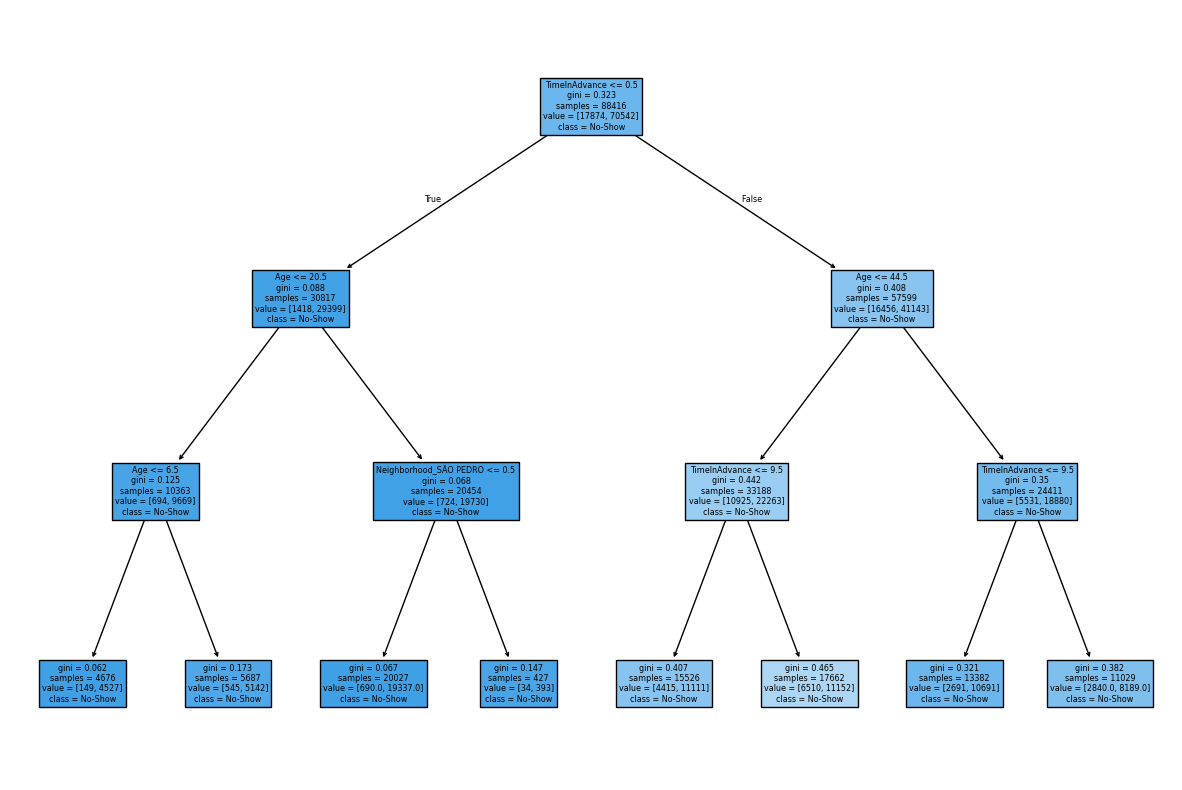

In [78]:
plt.figure(figsize=(15, 10))
plot_tree(dtc, filled=True, feature_names=X.columns, class_names=['Show', 'No-Show'])
plt.show()
#Yes some make sense like if the time

**14. Now we will calculate the optimal tree depth.**
- Create a for-loop that cycles over all `max_depth` values between 2 and 50
- in each iteration fit the model to the training set and calculate the F-measure on the test set (using `f1_score`) and store the F_measure in a list
- print out the f1_score at each iteration
- make a plot of max_depth vs. `f1_score`
- Select an optimal tree depth based on the plot (look for where the F-measure flattens out)

**15.  Fit the tree model (again) using the optimal depth and call this `final_model`.  Create the 2x2 confusion matrix using the predictions on the test set, vs the true values of the test set (make sure your confusion matrix is labelled). Calculate precision and recall (either directly from the 2x2 matrix, or by using the functions `precision_score` and `recall_score`)**

**16. Calculate the feature importance values for the features in `final_model`.  Comment on what the most important features are in estimating no-shows (and what isn't).  Are you surprised at what was and what was not important?  Comment on how you might you deal with this knowledge in making your office more efficient.**

**17. The F_measure above was calculated using a threshold of 0.5 (this is the default in the tree fitting function).  As we discussed in class, changing the threshold will have an effect on precision and recall.  Plot a histogram of the predicted probabilities that come out of your final model (using `.predict_proba() )`.  Using what you learn from the histogram, select a different threshold for labelling a patient as a No-show. Calculate precision, recall, and F-measure for your threshold and compare it to the default threshold of 0.5.  Comment on the tradeoff between the two thresholds, what are the pros and cons?  Which threshold would you choose?**